In [231]:
import torch
import xesmf as xe
import xarray as xr
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

plt.rcParams["font.family"] = "DejaVu Serif"
plt.rcParams['font.size'] = 8
plt.rcParams['figure.dpi'] = 200
plt.rcParams['axes.linewidth'] = 2
plt.rcParams['font.weight'] = "bold"
plt.rcParams['legend.framealpha'] = 0

In [73]:
##taken from aqua_argo_prepro script

In [3]:
x = xr.open_dataset('../data/GLDAS/GLDAS_NOAH025_M.A200107.021.nc4')
x

<xarray.Dataset>
Dimensions:                (time: 1, bnds: 2, lon: 1440, lat: 600)
Coordinates:
  * time                   (time) datetime64[ns] 2001-07-01
  * lon                    (lon) float32 -179.9 -179.6 -179.4 ... 179.6 179.9
  * lat                    (lat) float32 -59.88 -59.62 -59.38 ... 89.62 89.88
Dimensions without coordinates: bnds
Data variables: (12/37)
    time_bnds              (time, bnds) datetime64[ns] ...
    Swnet_tavg             (time, lat, lon) float32 ...
    Lwnet_tavg             (time, lat, lon) float32 ...
    Qle_tavg               (time, lat, lon) float32 ...
    Qh_tavg                (time, lat, lon) float32 ...
    Qg_tavg                (time, lat, lon) float32 ...
    ...                     ...
    Rainf_f_tavg           (time, lat, lon) float32 ...
    Tair_f_inst            (time, lat, lon) float32 ...
    Qair_f_inst            (time, lat, lon) float32 ...
    Psurf_f_inst           (time, lat, lon) float32 ...
    SWdown_f_tavg          (time, lat, lon) float32 ...
    LWdown_f_tavg          (time, lat, lon) float32 ...
Attributes: (12/19)
    CDI:                    Climate Data Interface version 1.9.8 (https://mpi...
    Conventions:            CF-1.6
    history:                created on date: 2019-10-30T04:22:24.381
    source:                 Noah_v3.6 forced with GDAS-AGRMET-GPCPv13rA1
    institution:            NASA GSFC
    missing_value:          -9999.0
    ...                     ...
    MAP_PROJECTION:         EQUIDISTANT CYLINDRICAL
    SOUTH_WEST_CORNER_LAT:  -59.875
    SOUTH_WEST_CORNER_LON:  -179.875
    DX:                     0.25
    DY:                     0.25
    CDO:                    Climate Data Operators version 1.9.8 (https://mpi...

In [4]:
Qs_GLDAS = x.Qs_acc
Qsb_GLDAS = x.Qsb_acc

print(Qs_GLDAS.shape,Qsb_GLDAS.shape)

(1, 600, 1440) (1, 600, 1440)


In [5]:
#now i want to get sst.

In [6]:
x1 = xr.open_dataset('../data/MODIS/AQUA_MODIS.20020701_20020731.L3m.MO.NSST.sst.9km.nc')
x1

<xarray.Dataset>
Dimensions:   (lat: 2160, lon: 4320, rgb: 3, eightbitcolor: 256)
Coordinates:
  * lat       (lat) float32 89.96 89.88 89.79 89.71 ... -89.79 -89.88 -89.96
  * lon       (lon) float32 -180.0 -179.9 -179.8 -179.7 ... 179.8 179.9 180.0
Dimensions without coordinates: rgb, eightbitcolor
Data variables:
    sst       (lat, lon) float32 ...
    qual_sst  (lat, lon) float32 ...
    palette   (rgb, eightbitcolor) uint8 ...
Attributes: (12/59)
    product_name:                     AQUA_MODIS.20020701_20020731.L3m.MO.NSS...
    instrument:                       MODIS
    title:                            MODISA Level-3 Standard Mapped Image
    project:                          Ocean Biology Processing Group (NASA/GS...
    platform:                         Aqua
    temporal_range:                   26-day
    ...                               ...
    publisher_url:                    https://oceandata.sci.gsfc.nasa.gov
    processing_level:                 L3 Mapped
    cdm_data_type:                    grid
    data_bins:                        4552793
    data_minimum:                     -1.675
    data_maximum:                     35.015

In [7]:
sst = x1.sst
print(sst.shape)

(2160, 4320)


In [8]:
# regridding_object = xe.Regridder(Qs_GLDAS,sst,method='bilinear')

In [9]:
# print('done')

In [10]:
# regridding_object.to_netcdf()

In [74]:
# z = regridding_object(Qs_GLDAS)
# z = np.where(z==0,np.nan,z)

In [41]:
### already did regrid, so now open to reuse

weights = xr.open_dataset('../data/bilinear_600x1440_2160x4320.nc')

regrid = xe.Regridder(Qs_GLDAS,sst,method='bilinear',weights=weights)
Qs_GLDAS_rg = regrid(Qs_GLDAS)
Qsb_GLDAS_rg = regrid(Qsb_GLDAS)

def replace_nan(z,val):
    z = np.where(z==val,np.nan,z)
    return z

Qs = replace_nan(Qs_GLDAS_rg,0)
Qsb = replace_nan(Qsb_GLDAS_rg,0)

In [58]:
a3 = torch.from_numpy(a1) + torch.from_numpy(a2)
a3.shape

torch.Size([1000, 1300])

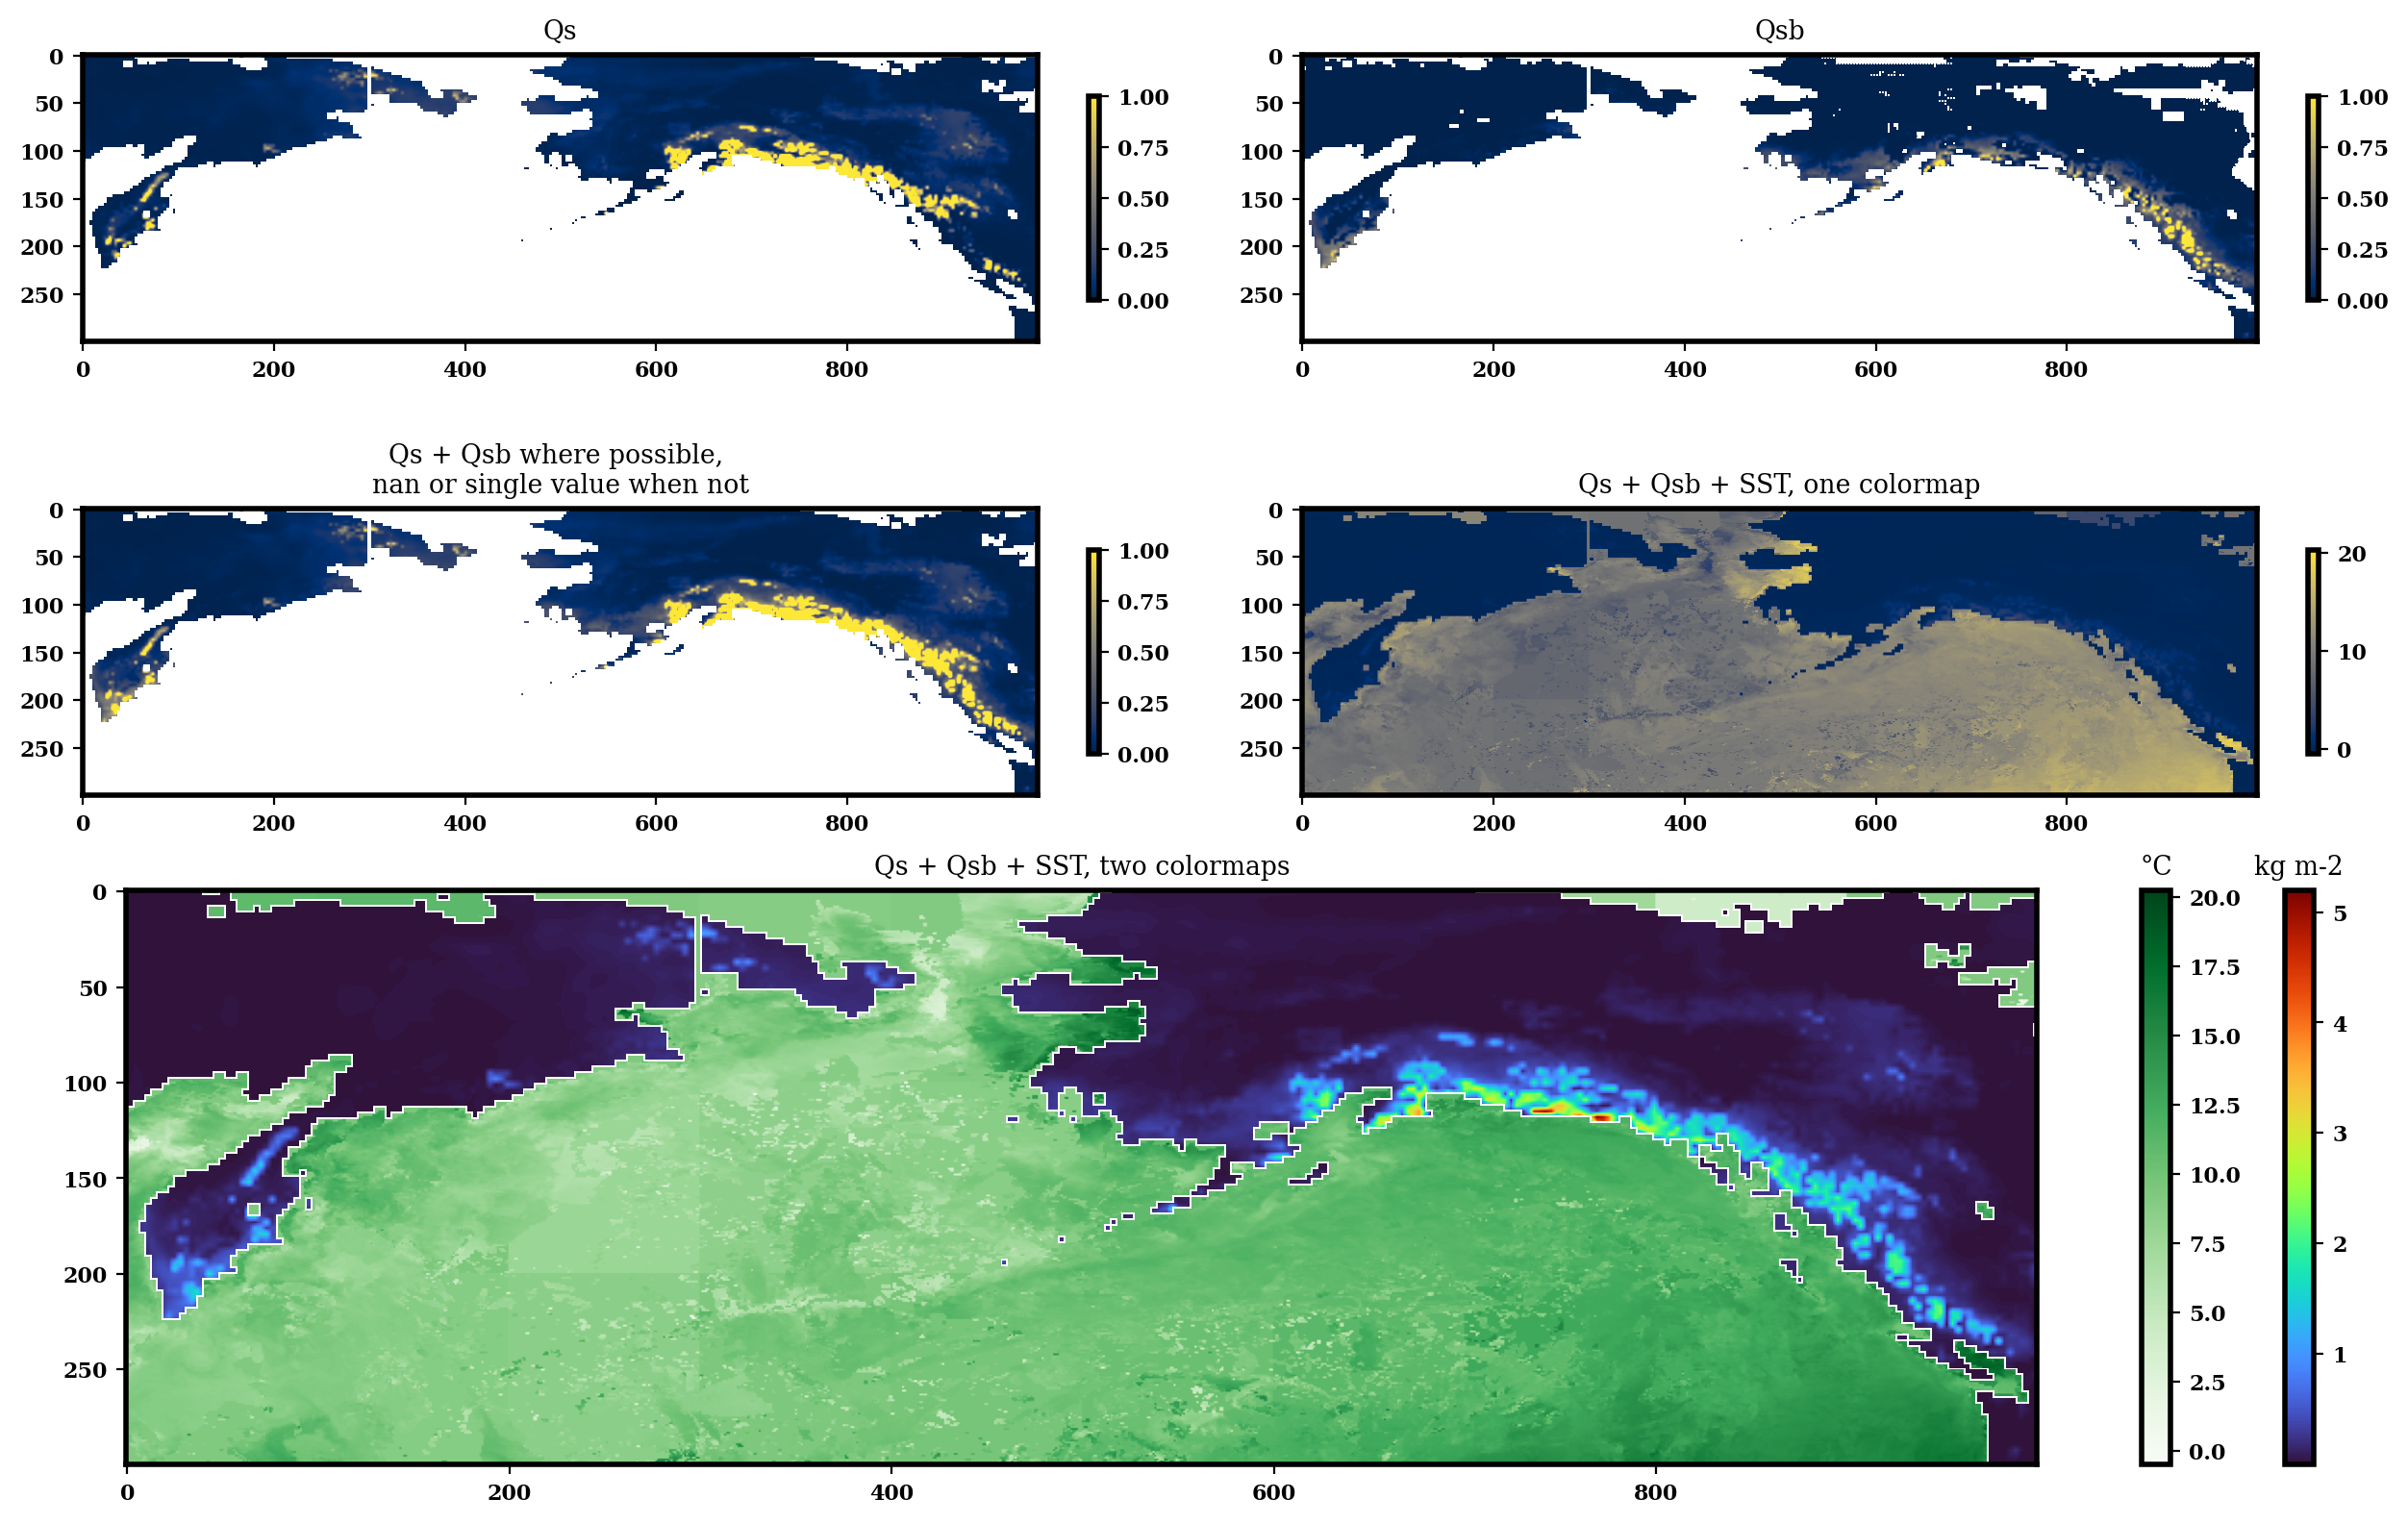

In [255]:
def foldit(x):
    x0 = x.reshape(-1,1,x.shape[2]*x.shape[3]).permute(1,2,0)
    fold = torch.nn.Fold(output_size=(A4.shape[2],A4.shape[3]),kernel_size=(patchsize,patchsize),stride=(patchsize,patchsize))
    return fold(x0)


fig = plt.figure(figsize=(15,10))
gs = gridspec.GridSpec(nrows=3,ncols=1,hspace=.05,wspace=.2,width_ratios=[1],height_ratios=[.3,.3,.4])


vmin = 0
vmax = 1
cmap = mpl.colormaps['cividis']
a1 = np.roll(Qs[0],1000)[:1000,500:1800]
a2 = np.roll(Qsb[0],1000)[:1000,500:1800]
a1_bool = np.where(np.isnan(a1) == True, 1, 0)
a2_bool = np.where(np.isnan(a2) == True, 1, 0)
a1_0 = np.where(np.isnan(a1) == True, 0, a1)
a2_0 = np.where(np.isnan(a2) == True, 0, a2)
a3_0 = a1_0 + a2_0
a3_bool = np.where((a1_bool == 0) | (a2_bool == 0),a3_0,np.nan)

a1 = a1[240:540,200:1200]
a2 = a2[240:540,200:1200]
a3 = a3_bool[240:540,200:1200]
a4 = np.roll(sst,1000)[:1000,500:1800]
a4 = a4[240:540,200:1200]
A4 = torch.from_numpy(a4).unsqueeze(0).unsqueeze(0)
patchsize = 100
unfoldobj = torch.nn.Unfold(kernel_size = (patchsize,patchsize),stride=int((patchsize/1)))
mask_patches = unfoldobj(A4).permute(2,0,1).reshape(-1,1,patchsize,patchsize)
d = [torch.where(torch.isfinite(x) == True, x, torch.nanmean(x)) for x in mask_patches]
for idx,x in enumerate(d):
    if idx == 0:
        e = x
    else:
        e = torch.cat((e,x))
e = e.unsqueeze(1)
ya = foldit(e)

xxxx = np.where(np.isfinite(a3) == True, a3, ya[0,0])


sub0 = gs[0].subgridspec(1,2)
sub1 = gs[1].subgridspec(1,2)

fig.add_subplot(sub0[0])
plt.imshow(a1,
           vmin=vmin,
           vmax=vmax,
          cmap=cmap)
plt.title('Qs')
plt.colorbar(fraction=.01)

fig.add_subplot(sub0[1])

plt.imshow(a2,
           vmin=vmin,
           vmax=vmax,
          cmap=cmap)
plt.title('Qsb')
plt.colorbar(fraction=.01)

fig.add_subplot(sub1[0])
plt.imshow(a3,
           vmin=vmin,
           vmax=vmax,
          cmap=cmap)
plt.title('Qs + Qsb where possible, \nnan or single value when not')
plt.colorbar(fraction=.01)

fig.add_subplot(sub1[1])
plt.imshow(xxxx,cmap = cmap)
plt.title('Qs + Qsb + SST, one colormap')
plt.colorbar(fraction=.01)


fig.add_subplot(gs[2])
plt.imshow(np.where(np.isnan(a3) == False, a3,np.nan),cmap='turbo')
plt.title('Qs + Qsb + SST, two colormaps')
plt.gca().set_aspect('equal')
clb = plt.colorbar(fraction=.015,location='right')
clb.ax.set_title('kg m-2')
plt.imshow(np.where(np.isnan(a3) == True, xxxx, np.nan),cmap='Greens')
clb = plt.colorbar(fraction=.015,location='right')
clb.ax.set_title('°C');